In [1]:
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os
os.environ['DISABLE_MPI']="true"
import numpy as np
from falafel import utils, qe
import pytempura
import solenspipe
from pixell import lensing, curvedsky, enmap
from pixell import utils as putils
from os.path import join as opj
import argparse
import yaml
from collections import OrderedDict
from prepare_maps import safe_mkdir, get_disable_mpi, DEFAULTS, get_cmb_alm_unlensed, get_cmb_seeds
from orphics import maps
from websky_model import WebSky, CONVERSION_FACTORS
from copy import deepcopy
import sys
from scipy.signal import savgol_filter

/global/u1/m/maccrann/cmb/ksz2/prepare_maps.py:48: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEFAULTS=yaml.load(f)


Set some options e.g. l ranges, beam, noise level for filters  

In [2]:
#lmax for SHTs
mlmax=4000
#lmin and lmax for filter
lmin=3000
lmax=4000
#beam and noise
noise_sigma = 10.
beam_fwhm = 1.
ells = np.arange(mlmax+1)
bfact = maps.gauss_beam(beam_fwhm,ells)**2.
Nl_tt = (noise_sigma*np.pi/180./60.)**2./bfact
nells = {"TT":Nl_tt, "EE":2*Nl_tt, "BB":2*Nl_tt}

In [57]:
#CMB theory for filters                                                                                                                                                                                 
ucls,tcls = utils.get_theory_dicts(grad=False,
                                   nells=nells, lmax=mlmax)

Read in CIB map, convert to temperature, and then to alms

In [4]:
#And ksz2 filter                                                                                                                                                                                        
#Read alms and get (smoothed) Cl for filter                                                                                                                                                                                                                                                                                                                                                      
alm_file = "tests/alms_4e3_2048_50_50_ksz.fits"
ksz_alms=hp.fitsfunc.read_alm(alm_file)
alm_lmax=hp.Alm.getlmax(len(ksz_alms))
if alm_lmax>mlmax:
    ksz_alms = utils.change_alm_lmax(
        ksz_alms, mlmax)
elif alm_lmax<mlmax:
    raise ValueError("alm_lmax (=%d) < mlmax (=%d)"%(
        alm_lmax, mlmax)
                     )
    
cl = curvedsky.alm2cl(ksz_alms)
d = ells*(ells+1)*cl
d_smooth = savgol_filter(d, 101, 3)
cl_smooth = d_smooth/ells/(ells+1)
cl_smooth[0]=0.
profile = cl_smooth**0.5

#Add kSZ cl to total Cl. Not sure if this 
#makes much difference.
cl_tt_total = tcls['TT'] + cl_smooth

def apply_W_filter(alms, lmin, lmax):
    f = np.zeros(mlmax+1)
    f[lmin:lmax+1] = (profile / cl_tt_total)[lmin:lmax+1]
    return curvedsky.almxfl(alms, f)

def get_cl_KK(alms, lmin, lmax):
    alms_filtered = apply_W_filter(alms, lmin, lmax)
    print(alms_filtered.shape)
    K_map = (hp.alm2map(alms_filtered, 4096))**2
    return hp.anafast(K_map, lmax=mlmax)

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [58]:
#Also get a CMB N_0
#Can we use tempura for this?
import pytempura
tcls['TT']+=cl_smooth
cmb_norm_source = pytempura.get_norms(
        ['src'], ucls, tcls,
        lmin, lmax, k_ellmax=mlmax,
        profile=profile)['src']
#I think normalization for K should be 
cmb_N0 = 4 * cl_smooth * cmb_norm_source**-1

/global/u1/m/maccrann/cmb/lensing/code/tempura/pytempura/norm.py:104: RuntimeWarning: divide by zero encountered in true_divide
  cl_tt = tcl['TT'][:k_ellmax+1]/profile**2
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in reciprocal
  # Remove the CWD from sys.path while we load stuff.
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


In [60]:
#Test by comparison to random realization
cmb_alm = get_cmb_alm_unlensed(0,0)[0]
cmb_alm = utils.change_alm_lmax(
                cmb_alm, mlmax)
print(cmb_alm.shape)
noise_alm = curvedsky.rand_alm(nells['TT'], seed=1234)
ksz_alm = curvedsky.rand_alm(cl_smooth, seed=1235)
cmb_alm += noise_alm
cmb_alm += ksz_alm
print(cmb_alm.shape)
cmb_cl_KK = get_cl_KK(cmb_alm, lmin, lmax)

(8006001,)
(8006001,)
(8006001,)


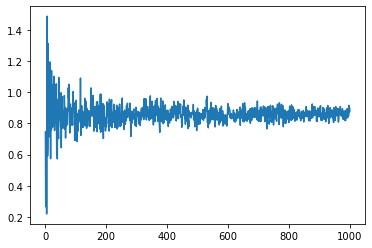

In [61]:
%matplotlib inline
fig,ax=plt.subplots()
#ax.plot(cmb_N0[:1000])
#ax.plot(cmb_cl_KK[:1000])
#ax.set_yscale('log')
#ax.set_ylim([1.e2, 1.e4])
ax.plot(cmb_cl_KK[:1000] / cmb_N0[:1000])

In [12]:
nu = "0093"
cib_map = hp.read_map("/global/cscratch1/sd/maccrann/cmb/websky/cib_nu%s.fits"%nu)
cib_flux_mJY = cib_map * 1.e9 * hp.nside2pixarea(4096)
cib_map -= cib_map.mean()
cib_map *= CONVERSION_FACTORS['CIB'][nu]

#read in 545Ghz map
cib_map_545 = hp.read_map("/global/cscratch1/sd/maccrann/cmb/websky/cib_nu0545.fits")
#convert to flux in mJY
cib_545_flux_mJY = cib_map_545 * 1.e9 * hp.nside2pixarea(4096)
mask_flux = 7.
planck_545_mask_flux = 350.

flux_mask = cib_flux_mJY<mask_flux
plmask = cib_545_flux_mJY<planck_545_mask_flux
print("flux cut masking f_sky:", (float(len(flux_mask)-flux_mask.sum())/len(flux_mask)))
print("545 GHz cut masking f_sky:", (float(len(plmask)-plmask.sum())/len(plmask)))
cib_map_masked = cib_map * flux_mask
cib_map_plmasked = cib_map * plmask

/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))

flux cut masking f_sky: 3.129243850708008e-06
545 GHz cut masking f_sky: 8.057554562886556e-05


Build filter. The filter is $(C_l^{ksz})^{0.5}/C_l^{\mathrm{total}}$. 
Start by getting the CMB part using `falafel.utils.get_theory_dict`

Now read in the kSZ alms, measure $C_l$, smooth it, and add to the total $C_l$

In [13]:
cib_maps = [cib_map, cib_map_masked, cib_map_plmasked]
keys = ["cib", "cib_masked", "cib_plmasked"]
labels = ["cib %s"%nu, "cib %s, >%f mJY masked"%(nu, mask_flux),
        "cib %s, >%f at 545GHz masked"%(nu, planck_545_mask_flux)]

cl_KK_dict = {}

for m,k in zip(cib_maps, keys):
    cib_alms = hp.map2alm(m, lmax=mlmax)
    cib_cl_KK = get_cl_KK(cib_alms, lmin, lmax)
    #first get the C_l
    cib_cl = curvedsky.alm2cl(cib_alms)
    #Now generate the random alms
    sim_alm = curvedsky.rand_alm(cib_cl, seed=1234)
    sim_cl_KK = get_cl_KK(sim_alm, lmin, lmax)
    cl_KK_dict[k] = (cib_cl_KK, sim_cl_KK)
    print(cib_cl_KK, sim_cl_KK)

(8006001,)


/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/m/maccrann/.conda/envs/lenspipe/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


(8006001,)
[4.86762028e+08 1.37755479e+06 2.06236842e+06 ... 8.91220455e+03
 8.68898027e+03 8.85808837e+03] [4.86841230e+08 6.72046765e+01 3.14939498e+02 ... 1.34938377e+01
 1.30662115e+01 1.29402725e+01]
(8006001,)
(8006001,)
[3.26907383e+08 1.69803537e+04 3.97488365e+03 ... 1.06825713e+01
 1.05247642e+01 1.04239845e+01] [3.26960934e+08 4.51419743e+01 2.12424454e+02 ... 9.06833856e+00
 8.78074944e+00 8.69447398e+00]
(8006001,)
(8006001,)
[3.24934267e+08 4.25658004e+04 1.99124267e+04 ... 8.12944316e+01
 8.06928454e+01 8.04030561e+01] [3.24987567e+08 4.46586541e+01 2.11393506e+02 ... 9.01308795e+00
 8.72641816e+00 8.64223088e+00]


In [21]:
from solenspipe import weighted_bin1D
def bin_cl(cl, lmin=10, lmax=500, nbin=30):
    bin_edges = np.linspace(0,lmax,nbin).astype(int)
    binner = weighted_bin1D(bin_edges)
    ix,weights = np.zeros_like(cl), np.ones_like(cl)
    return binner.bin(ix, cl, weights)

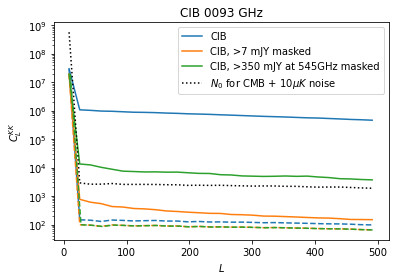

In [56]:
%matplotlib inline
fig,ax=plt.subplots()

ell_mids, cl_KK_cib_binned = bin_cl(cl_KK_dict['cib'][0])

ax.plot(ell_mids, cl_KK_cib_binned, color='C0', label='CIB')
ax.plot(ell_mids, bin_cl(cl_KK_dict['cib'][1])[1], color='C0', linestyle='--')
ax.plot(ell_mids, bin_cl(cl_KK_dict['cib_masked'][0])[1], 
        color='C1', label='CIB, >%d mJY masked'%mask_flux)
ax.plot(ell_mids, bin_cl(cl_KK_dict['cib_masked'][1])[1],
       color='C1', linestyle='--')
ax.plot(ell_mids, bin_cl(cl_KK_dict['cib_plmasked'][0])[1], 
        color='C2', label='CIB, >%d mJY at 545GHz masked'%planck_545_mask_flux)
ax.plot(ell_mids+2., bin_cl(cl_KK_dict['cib_plmasked'][1])[1],
       color='C2', linestyle='--')
ax.plot(ell_mids, bin_cl(cmb_cl_KK)[1], label=r'$N_0$'+' for CMB + 10$\mu K$ noise',
       color='k', linestyle=':')
#ax.plot([],[],color='k',linestyle='--',label=r'CIB $N_0$')
ax.set_yscale('log')
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$C_L^{KK}$")
ax.set_title("CIB %s GHz"%nu)
ax.legend()
fig.savefig('cib_N0_%s.png'%nu)

Now apply the filter and get the K map, and measure it's $C_l$. 

In [ ]:
#Filter the cib alms
cib_alms = hp.map2alm(cib_map,lmax=mlmax)
print(cib_alms.shape)
cib_alms_filtered = apply_W_filter(cib_alms,lmin,lmax)
print(cib_alms_filtered.shape)
#hp.fitsfunc.write_alm("cib_alms_filtered_%s.fits"%tag, cib_alms_filtered, overwrite=True)

#K is squared, filtered map
cib_K_map = (hp.alm2map(cib_alms_filtered, 4096))**2

In [ ]:
#Get C(l) of K map
cib_K_alm = (hp.map2alm(cib_K_map, lmax=1000))
cib_cl_KK = hp.alm2cl(cib_K_alm)

Ok so that's the raw auto for the CIB map. Now get the $N_0$. For this we just measure the power spectrum of the input CIB map, generate a Gaussian sim, and make the same measurement on that sim. 

In [ ]:
#first get the C_l
cib_cl = curvedsky.alm2cl(cib_alms)

In [ ]:
#Now generate the random alms
sim_alm = curvedsky.rand_alm(cib_cl, seed=1234)

Make sure this has the right power spectrum

In [ ]:
%matplotlib inline
fig,ax=plt.subplots()
#the one we measured from the cib alms
ax.plot(cib_cl)
#the one from the alms we just generated
ax.plot(curvedsky.alm2cl(sim_alm))
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
sim_alm_filtered = apply_W_filter(sim_alm)
#Convert to K map
sim_K_map = (hp.alm2map(sim_alm_filtered, 4096))**2
#Convert to alms and get C_l
sim_K_alm = hp.map2alm(sim_K_map, lmax=1000)
sim_cl_KK = hp.alm2cl(sim_K_alm)

Now plot both

In [ ]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(cib_cl_KK, label="CIB map")
ax.plot(sim_cl_KK, label='$N_0$')
ax.legend()
#ax.set_ylim([1.e-10,1.e-8])
ax.set_yscale('log')
fig.savefig("Cl_KK_%s.png"%(tag))

WTF. $N_0$ is way smaller...

Plot some maps

In [ ]:
res=1. #arcmin
shape,wcs = enmap.geometry((np.pi,np.pi), res=res*putils.arcmin, shape=(500,500))
#shape,wcs = enmap.fullsky_geometry(res=res * putils.arcmin)
cib_map_filtered = enmap.zeros(shape,wcs)
sim_map_filtered = enmap.zeros(shape,wcs)
curvedsky.alm2map(cib_alms_filtered, cib_map_filtered)
curvedsky.alm2map(sim_alm_filtered, sim_map_filtered)

In [ ]:
%matplotlib inline
fig,ax=plt.subplots(nrows=4, figsize=(5,10))
im=ax[0].pcolormesh(cib_map_filtered)#, vmin=-10.,vmax=10.)
ax[0].set_title("Filtered CIB")
fig.colorbar(im, ax=ax[0])
im=ax[1].pcolormesh(sim_map_filtered)#, vmin=-10.,vmax=10.)
ax[1].set_title("Filtered Gaussian sim")
fig.colorbar(im, ax=ax[1])
im=ax[2].pcolormesh(cib_map_filtered**2)#, vmin=-10.,vmax=10.)
fig.colorbar(im, ax=ax[2])
ax[2].set_title("CIB K")
im=ax[3].pcolormesh(sim_map_filtered**2)#, vmin=-10.,vmax=10.)
fig.colorbar(im, ax=ax[3])
ax[3].set_title("Gaussian K")
fig.tight_layout()

In [ ]:
fig.savefig("cib_test_maps_%s.png"%(tag))